In [1]:
import pickle
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import sys,os
from util import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Upload example data 

In [2]:
inputs={}
neighs={}
with open('/content/drive/My Drive/echo/input_sample_poi.pickle','rb') as f:
  input_sample_poi=pickle.load(f)
with open('/content/drive/My Drive/echo/chromatin_feature.pickle','rb') as f:
  chromatin_feature=pickle.load(f)
inputs[21]= np.load('/content/drive/My Drive/echo/chr21.npy')
### get the first 100 samples to run an example
neighs[21]= np.load('/content/drive/My Drive/echo/neighbors_chr21.npy')[:100,:]



# Run analysis

In [3]:
### calculate the prediction scores of all 2583 chromatin features (882 TFs,1510 HMs and 191 DHSs)
### the contacts and neighbor sequences are attributed according to the TFs which have prediction scores greater than the threshold
prediction_scores, att_neighbors, att_contacts=echo_attribute(inputs,neighs,threshold=0.2)
print('finished')

cuda:0
step: 0001 time= 0.61025
finished


# Prediction scores on central sequence

In [4]:
example_chr=21
central_seq_idx=24
print("The selected central sequence is %s-%sbp with 400 bp " 
"flanking region both upstream and downstream \n"
%(input_sample_poi[example_chr][central_seq_idx],input_sample_poi[example_chr][central_seq_idx]+200))

### report the top 10 TFs with highest prediction scores
### prediction scores are the outputs of ECHO, which predict the chromatin features on central sequence
print('Top 10 TFs with highest prediction scores')
TF_indices=np.argsort(prediction_scores[example_chr][central_seq_idx,:882])[::-1][:10]
for idx in TF_indices:
  print(chromatin_feature[idx],prediction_scores[example_chr][central_seq_idx,idx])

The selected central sequence is 5103800-5104000bp with 400 bp flanking region both upstream and downstream 

Top 10 TFs with highest prediction scores
POLR2G	K562 0.6211419
RBFOX2	K562 0.5997548
SUPT5H	K562 0.4985994
AGO2	HepG2 0.4584897
POLR2G	HepG2 0.40812996
RBFOX2	HepG2 0.26083073
POLR2B	K562 0.20276928
RBM22	K562 0.18964835
SMAD5	K562 0.18350911
POLR2AphosphoS5	GM12878 0.16838981


# Attribution scores on chromatin contacts

In [5]:
neighbor_sequences=[]
if 'None' not in att_contacts[example_chr][central_seq_idx].keys():
  neighbor_sequences=list(att_contacts[example_chr][central_seq_idx].keys())
  sorted_neighbors= sorted(att_contacts[example_chr][central_seq_idx].items(), key=lambda item: item[1])[::-1]
  print("sequence: sequences that contact with the central sequence.\n"
  "distance: contact distance with the central sequence \nscore: corresponding attribution score on the chromatin contact \n")
  for n in sorted_neighbors:
    print('sequence: %s, distance %s, score: %s'%(input_sample_poi[example_chr][n[0]],input_sample_poi[example_chr][n[0]]-input_sample_poi[example_chr][central_seq_idx],n[1]))
else:
  print("No prediction scores for TF binding on the central sequence exceeds the set threshold")


sequence: sequences that contact with the central sequence.
distance: contact distance with the central sequence 
score: corresponding attribution score on the chromatin contact 

sequence: 5104400, distance 600, score: 1.0
sequence: 5103600, distance -200, score: 0.2634302079677582
sequence: 5104600, distance 800, score: 0.17225176095962524
sequence: 5103800, distance 0, score: 0.06908699870109558
sequence: 5103400, distance -400, score: 0.05749448761343956
sequence: 5102200, distance -1600, score: 0.05282595753669739
sequence: 5106000, distance 2200, score: 0.05268995463848114
sequence: 5104800, distance 1000, score: 0.044572580605745316
sequence: 5103000, distance -800, score: 0.04164285212755203
sequence: 5103200, distance -600, score: 0.007116787135601044
sequence: 5105800, distance 2000, score: 0.0013382271863520145


# Attribution scores on neighbor sequences

[25, 23, 26, 24, 22, 19, 29, 27, 20, 21, 28]
[5104400, 5103600, 5104600, 5103800, 5103400, 5102200, 5106000, 5104800, 5103000, 5103200, 5105800]
The selected central sequence is 5103800-5104000bp with 400 bp flanking region both upstream and downstream 



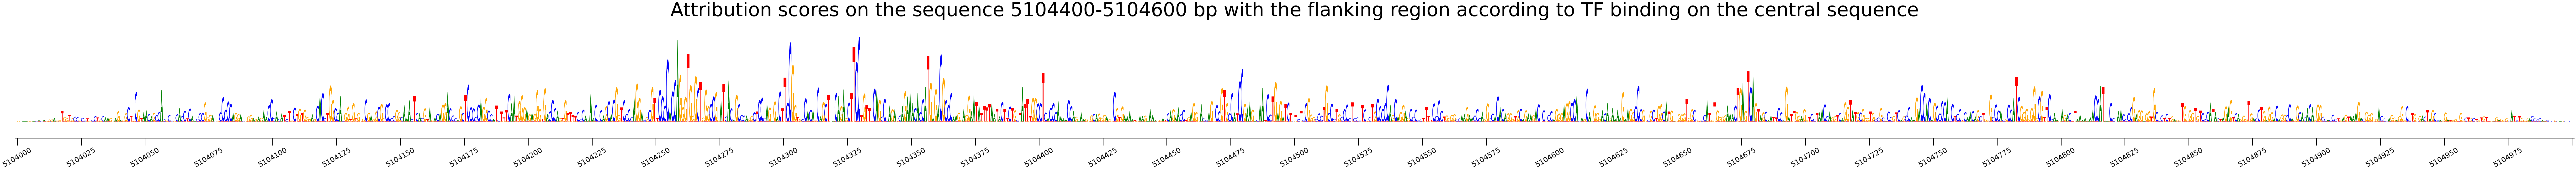

In [6]:
if neighbor_sequences:
  neighbors=[n[0] for n in sorted_neighbors]
  print(neighbors)
  print([input_sample_poi[example_chr][n[0]] for n in sorted_neighbors])
  print("The selected central sequence is %s-%sbp with 400 bp " 
"flanking region both upstream and downstream \n"
%(input_sample_poi[example_chr][central_seq_idx],input_sample_poi[example_chr][central_seq_idx]+200))
  plot_weights(att_neighbors[example_chr][central_seq_idx][25],input_sample_poi[example_chr][25])